In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
import numpy as np
import polars as pl
import itertools
from pathlib import Path
from dask import delayed
from runpy import run_path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import umap.umap_ as umap
import streamlit as st
from sklearn.preprocessing import StandardScaler

import local2global as l2g # ADDED

import torch
import torch_geometric as tg
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx
from torch_geometric.transforms import LargestConnectedComponents
from torch_geometric.utils import to_networkx, from_networkx, one_hot
#from torch_geometric.nn import Node2Vec, GCNConv, VGAE
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import l2gl
from l2gl.embedding import VGAE, GAE, VGAE_loss, GAE_loss
from l2gl.utils import DataLoader
from l2gl.patch import Patch, AlignmentProblem

In [4]:
import manopt_optimization as mopt

In [5]:
PATH = "../data/nas/"

# <font color="grey"> Autonomous Systems</font>

The purpose of this notebook is to walk through the graph embedding and alignment process in a self-contained way. The full existing Local2Global package is available [here](https://github.com/LJeub/Local2Global_embedding) and the expectation is to pick parts from it as a starting point. It is also available in on this repository in the Local2Global_embedding folder for reference.

### <font color="grey">  Table of Contents</font>

1. #### <a href='#chapter1'>Data</a>
2. #### <a href='#chapter2'>Embedding</a>
3. #### <a href='#chapter3'>Visualisation</a>

###  <a id='chapter1'> <font color="grey">1. Data </font></a>

The data can be accessed via the dataloader. It is saved in the datasets/data/nas directory in two parquet files. There are many alternative ways of doing this. One option to explore is to have the datasets available as in [torch_geometric datasets](https://pytorch-geometric.readthedocs.io/en/2.6.0/modules/datasets.html).

In [6]:
dl = DataLoader(dset='nas')

The data is stored in one dataframe for the nodes (including all the features) and one for the edges (including edge weights).

In [7]:
# Get the nodes
node_df = dl.get_nodes()
node_df.head()

timestamp,nodes,nodetype,country,asname,nodename,cc
datetime[μs],i64,str,str,str,str,i64
2024-09-14 00:00:00,0,"""asn""","""US""","""WINDSTREAM""","""AS7029""",235
2024-09-14 00:00:00,1,"""asn""","""US""","""RUELALA-INC""","""AS32984""",235
2024-09-14 00:00:00,2,"""asn""","""ID""","""FIBERSTAR-AS-I""","""AS136106""",104
2024-09-14 00:00:00,3,"""asn""","""ID""","""HSPNET-AS-I""","""AS58495""",104
2024-09-14 00:00:00,4,"""asn""","""US""","""BTN-ASN""","""AS3491""",235


In [8]:
edge_df = dl.get_edges()
edge_df.head()

timestamp,source,dest,weight
datetime[μs],i64,i64,i64
2024-09-14 00:00:00,0,1,1
2024-09-14 00:00:00,0,465,1
2024-09-14 00:00:00,0,596,1
2024-09-14 00:00:00,0,1234,1
2024-09-14 00:00:00,0,1272,1


Ultimately, working with the people at Pometry, we want to use the [Raphtory](https://www.raphtory.com/) graph format.

In [9]:
# Raphtory format
g = dl.get_graph()

The Raphtory formal is still work in progress but one can contribute to their code (based in Rust), contribute to the discussion on their Slack (linked on their page) or directly get in touch with [Lucas Jeub](https://github.com/LJeub) and/or Ben Steer.

In [10]:
print("Stats on the graph structure:")

number_of_nodes = g.count_nodes()
number_of_edges = g.count_edges()
total_interactions = g.count_temporal_edges()

print("Number of nodes (AS nodes):", number_of_nodes)
print("Number of unique edges (src,dst):", number_of_edges)
print("Total interactions (edge updates):", total_interactions)

print("Stats on the graphs time range:")

earliest_datetime = g.earliest_date_time
latest_datetime = g.latest_date_time

print("Earliest datetime:", earliest_datetime)
print("Latest datetime:", latest_datetime)

Stats on the graph structure:
Number of nodes (AS nodes): 85428
Number of unique edges (src,dst): 914346
Total interactions (edge updates): 16717484
Stats on the graphs time range:
Earliest datetime: 2024-09-14 00:00:00+00:00
Latest datetime: 2024-10-13 00:00:00+00:00


In [11]:
print("The node features are: ", g.nodes.properties.keys())

The node features are:  ['asname', 'cc', 'country', 'nodename', 'nodetype']


The graphs we are dealing are **temporal**, meaning that nodes and edges have timestamps. One can interpret this as having one graph for each point in time, with a possible overlap of nodes and edges.

In [12]:
dates = dl.get_dates()

For this particular dataset, the graph for each day represents a patch. In order to apply graph neural networks to each patch, we need to process these into the Data format used by pytorch-geometric, described [here](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html). In particular, for each patch we need to enumerate the nodes and use these indices to designate the nodes. We need a dictionary that maps the nodes in each patch to their names and we need to encode the node and edge features.

In [13]:
# Encode nodes present at each date
nodes = {}
node_dict = {}
for d in dates:
    nodes[d] = dl.get_node_list(ts=d)
    node_dict[d] = dict(zip(nodes[d],range(len(nodes[d]))))
all_nodes = dl.get_node_list()

In [14]:
numbering_nodes= {x : i for i, x in enumerate(all_nodes)}
list_nodes=list(nodes.values())

list_nodes_renumbered=[]
for l in list_nodes:
    list_nodes_renumbered.append( [numbering_nodes[i] for i in l])

In [15]:
# Encode country codes
cc = pl.read_csv(PATH+'country_codes.csv')
countrycode_dict = dict(zip(cc["alpha-2"].to_list(), range(cc.shape[0])))
#cc_one_hot = one_hot(torch.tensor(list(countrycode_dict.values()), dtype=torch.int64))

In [16]:
# Assign country code index to each node. The way this is done is a bit convoluted, as some nodes are assigned to both a country and to 'ZZ'
# in the database, so we need to fix that. This should be done in pre-processing
df = dl.get_nodes().with_columns(
    pl.col("country").replace(old=pl.Series(countrycode_dict.keys()), new=pl.Series(countrycode_dict.values())).cast(pl.Int64).alias('cc')
).select(["nodes", "cc"]).group_by("nodes").agg(pl.col("cc").min().cast(pl.Int64).alias("cc")).sort(["cc","nodes"])
node_cc_dict = dict(zip(df["nodes"].to_list(), df["cc"].to_list()))

In [17]:
# For every day, create a list of node features
features = {}
for d in dates:
    features[d] = one_hot(torch.tensor(dl.get_nodes(ts=d).select(
        pl.col("country").replace(old=pl.Series(countrycode_dict.keys()), new=pl.Series(countrycode_dict.values())).cast(pl.Int64)
    ).to_numpy().flatten()))

In [18]:
features[dates[3]].shape

torch.Size([84575, 250])

In [19]:
# Create pytorch-geometric Data object
tg_graphs = {}
for d in tqdm(dates):
    edges = dl.edges.filter(pl.col('timestamp')==d).select(
        pl.col('source').replace(old=pl.Series(node_dict[d].keys()), new=pl.Series(node_dict[d].values())).cast(pl.Int64),
        pl.col('dest').replace(old=pl.Series(node_dict[d].keys()), new=pl.Series(node_dict[d].values())).cast(pl.Int64)
    ).to_numpy()
    edge_index = torch.tensor([tuple(x) for x in edges], dtype=torch.long).t().contiguous()
    tgraph = Data(edge_index=edge_index)
    # Add features - problem is that for the embedding we only want those present at a given time
    tgraph.x = features[d]
    tg_graphs[d] = tgraph

  0%|          | 0/30 [00:00<?, ?it/s]

In [20]:
for i, d in enumerate(dates):
    tg_graphs[d].nodes=torch.tensor(list_nodes_renumbered[i])

In [21]:
# Select one date to test embedding
data = tg_graphs[dates[0]]

###  <a id='chapter2'> <font color="grey">2. Embedding </font></a>

For the embedding, we use the architecture of a Variational Graph Autoencoder. Given a graph $G=(V,E)$ with $|V|=n$ nodes and node features ${x}_i\in \mathbb{R}^d$, $i\in [n]$, denote by ${X}=[{x}_1,\dots,{x}_n]^T\in \mathbb{R}^{n\times d}$ the features matrix and by $A=(a_{ij})\in \{0,1\}^{n\times n}$ the adjacency matrix of the graph. The **encoder** produces latent representations ${z}_i\in \mathbb{R}^k$ for $i\in [n]$, which are sampled from the inference model
\begin{equation*}
  q({z}_i \ | \ {X},{A}) = \mathcal{N}({z}_i \ | \ {\mu}_i,\mathrm{diag}({\sigma}_i)).
\end{equation*}
The means $\mu_i$ and variances $\mathrm{diag}({\sigma}_i)$ are parametrized using an encoder network, for example, a graph convolutional neural network (GCN). Denoting by ${Z}=[{z}_1,\dots,{z}_n]^T$ the matrix of latent represenations and by ${\mu}$ and ${\sigma}$ the matrices representing the means and variances, we have
\begin{equation*}
  {\mu} = \mathrm{GCN}_{\mu}({X},{A}), \quad \quad \log {\sigma} = \mathrm{GCN}_{\sigma}({X},{A}).
\end{equation*}
The **generative model** is a distribution on the adjacency matrix,
\begin{equation*}
  p({A}\ | \ {Z}) = \prod_{i,j} p(a_{ij} \ | \ {z}_i,{z}_j).
\end{equation*}
It is convenient to use
\begin{equation*}
  p(a_{ij}=1 \ | \ {z}_i,{z}_j) = \sigma({z}_i^T{z}_j),
\end{equation*}
where $\sigma$ is the logistic sigmoid. In order to train the model, we optimize the evidence lower bound
\begin{equation*}
  \mathcal{L} = \mathbb{E}_{q({Z}\ | \ {X},{A})}[\log p({A}\ | \ {Z})]-\mathrm{D}_{\mathrm{KL}}(q({Z}\ | \ {X},{A}) \ \| \ p({Z})).
\end{equation*}

In [22]:
model = VGAE(dim=64, hidden_dim=128, num_features=data.num_node_features)

In [23]:
def train(data, model, loss_fun, num_epochs=100, verbose=True, lr=0.01, logger=lambda loss: None):
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    # schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
    for e in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        loss = loss_fun(model, data)
        loss.backward()
        optimizer.step()
        losses.append(float(loss))
        if verbose:
            if not e % 20:
                print(f'epoch {e}: loss={loss.item()}')
        # schedule.step()
    return model, losses

In [24]:
model, losses = train(data, model,VGAE_loss, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch 0: loss=6.612922668457031
epoch 20: loss=1.021452784538269
epoch 40: loss=0.9126554131507874
epoch 60: loss=0.8899462819099426
epoch 80: loss=0.8759779334068298


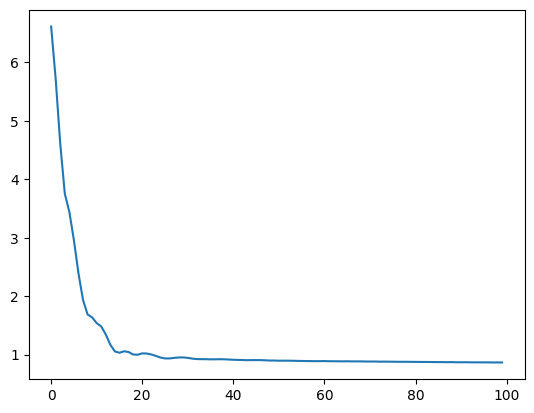

In [25]:
plt.plot(losses)
plt.show()

In [26]:
embedding = model.encode(data).detach().numpy()
embedding.shape

(84592, 64)

In the original L2G code, there is a Patch class handling patches.

###  <a id='chapter3'> <font color="grey">3. Visualisation </font></a>

In [27]:
most_common = ['AU', 'BR', 'CN', 'DE', 'IN', 'ID', 'PL', 'RU', 'GB', 'US']
countries = dl.get_nodes(ts=dates[0])['country'].to_list()
indices = [i for i in range(len(countries)) if countries[i] in most_common]

In [28]:
points = embedding[indices, :]
labels = [most_common.index(countries[i]) for i in indices]

In [29]:
# Use UMAP to visualise the graph embeddings for different days
reducer = umap.UMAP(n_neighbors=5, min_dist=0.01, metric='euclidean')

In [30]:
#points = StandardScaler().fit_transform(points)
points

array([[ 0.22137403, -0.11188032,  0.20254458, ..., -0.39334825,
         0.01145795,  0.30327272],
       [ 0.28838855, -0.14233944,  0.2750637 , ..., -0.587349  ,
         0.03135241,  0.4099504 ],
       [ 0.03325326,  0.14349377, -0.12260471, ...,  0.39588252,
         0.182359  ,  0.11646201],
       ...,
       [ 0.1929253 ,  0.35990706, -0.17947713, ...,  0.04694361,
        -0.00763192, -0.17743707],
       [ 0.08042599,  0.291812  , -0.06403939, ...,  0.07137524,
         0.0445147 , -0.03364534],
       [ 0.22860405,  0.132901  , -0.1272966 , ...,  0.20737308,
        -0.02360138, -0.11601394]], dtype=float32)

In [31]:
umap_embedding = reducer.fit_transform(points)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


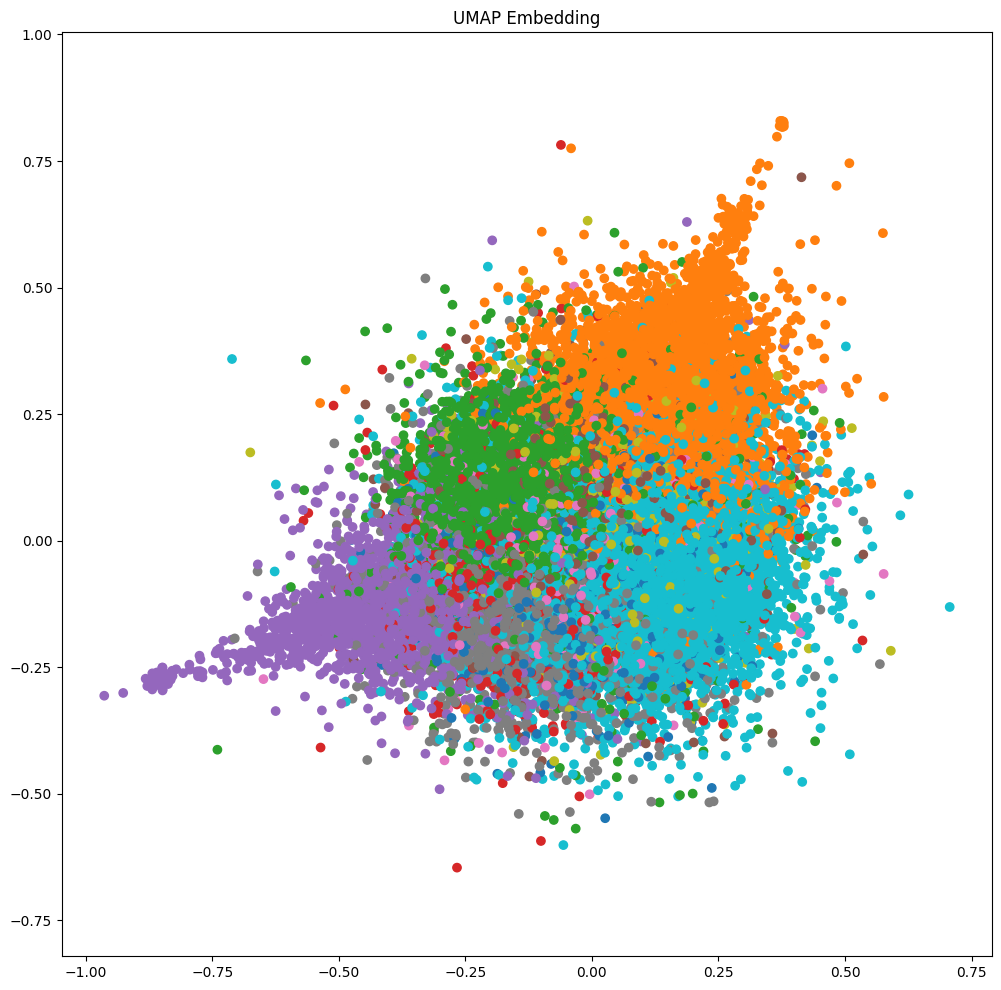

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(
    points[:, 0],
    points[:, 1],
    c=[sns.color_palette()[x] for x in labels],
    lw=1
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Embedding', fontsize=12)
plt.show()

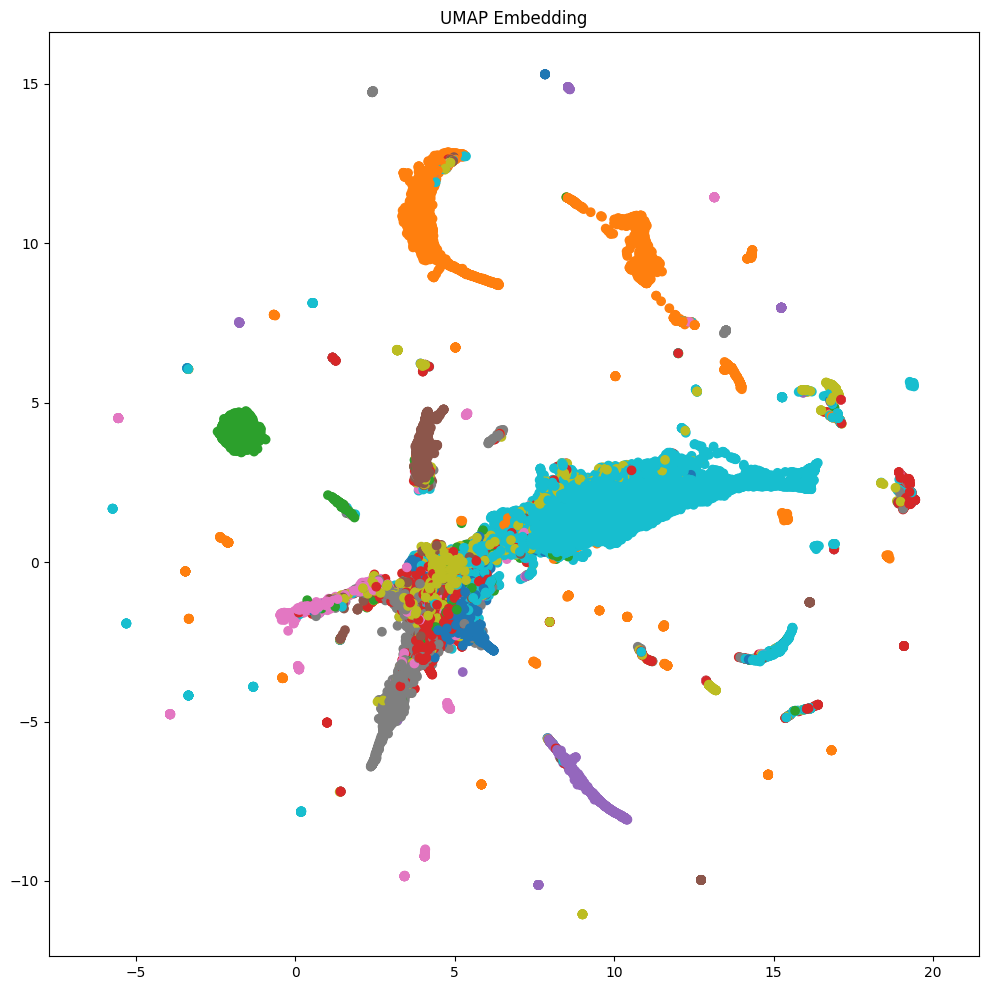

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=[sns.color_palette()[x] for x in labels],
    lw=1
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Embedding', fontsize=12)
plt.show()

In [34]:
#patch_list = []
models = []
embeddings = []
patch_emb=[] #ADDED
for d in dates[:5]:
    patch = tg_graphs[d]
    model = model = VGAE(dim=64, hidden_dim=128, num_features=data.num_node_features)
    model, _ = train(patch, model, VGAE_loss, num_epochs=5, lr=0.01)
    patch_emb.append(Patch(patch.nodes, model.encode(patch).detach().numpy())) #ADDED
    #coordinates = model.encode(patch).detach().numpy()
    models.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0: loss=6.6967549324035645


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0: loss=6.753963947296143


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0: loss=6.5766143798828125


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0: loss=6.573153018951416


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0: loss=6.687312126159668


In [ ]:
# Optimization on manifolds approach
intersection_nodes=mopt.double_intersections_nodes(patch_emb)
dim=64
res, emb = mopt.optimization(patch_emb, intersection_nodes, dim) #res contain the result of the optimization, i.e., scales, rotations and traslations,
                                                                # emb is the embedding of every nodes using the scales, rotations and translations 
                                                                #found with  the optimization

In [ ]:
# Standard l2g approach
pr = AlignmentProblem(patch_emb)
old_emb = pr.get_aligned_embedding()

In [36]:
def reduce_data(data, date, most_common):
    countries = dl.get_nodes(ts=date)['country'].to_list()
    indices = [i for i in range(len(countries)) if countries[i] in most_common]
    points = data[indices, :]
    labels = [most_common.index(countries[i]) for i in indices]
    return points, labels

In [37]:
def create_plot(umap_embedding, labels, p):
    fig, ax = plt.subplots(1, 1, figsize=(12,12))
    ax.scatter(
        umap_embedding[p][:, 0],
        umap_embedding[p][:, 1],
        c=[sns.color_palette()[x] for x in labels[p]],
        lw=1
    )
    return fig

In [49]:
# Compute all embeddings (using GAE)
dim = 64
#patch_list = []
models = []
embeddings = []
patch_emb = [] #ADDED
for d in dates[:5]:
    patch = tg_graphs[d]
    model = GAE(dim=64, hidden_dim=128, num_features=data.num_node_features)
    model, _ = train(patch, model, GAE_loss, num_epochs=40, lr=0.01)
    patch_emb.append(Patch(patch.nodes, model.encode(patch).detach().numpy())) #ADDED
    #coordinates = model.encode(patch).detach().numpy()
    models.append(model)

  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.797112941741943
epoch 20: loss=0.9995319247245789


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.675680160522461
epoch 20: loss=0.9898103475570679


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.5298919677734375
epoch 20: loss=1.007838487625122


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.669097423553467
epoch 20: loss=1.0373005867004395


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.691777229309082
epoch 20: loss=1.0391356945037842


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.643961429595947
epoch 20: loss=0.9997661113739014


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.679520130157471
epoch 20: loss=0.9856821298599243


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.671051979064941
epoch 20: loss=0.9905226826667786


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.628060340881348
epoch 20: loss=0.9780886769294739


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.6673502922058105
epoch 20: loss=0.9920098781585693


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.662076950073242
epoch 20: loss=1.0108779668807983


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.626396179199219
epoch 20: loss=0.999188244342804


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.663871765136719
epoch 20: loss=1.0227240324020386


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.635674953460693
epoch 20: loss=0.9973846077919006


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.593784332275391
epoch 20: loss=0.9962922930717468


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.546481609344482
epoch 20: loss=1.0094605684280396


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.69603967666626
epoch 20: loss=0.9863232970237732


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.653092861175537
epoch 20: loss=1.0383065938949585


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.602849006652832
epoch 20: loss=0.9920666813850403


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.726089000701904
epoch 20: loss=0.9813836812973022


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.583628177642822
epoch 20: loss=0.99765944480896


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.647061347961426
epoch 20: loss=0.982408881187439


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.580122947692871
epoch 20: loss=1.030287742614746


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.615525722503662
epoch 20: loss=1.0500472784042358


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.650845050811768
epoch 20: loss=1.0245684385299683


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.691086769104004
epoch 20: loss=1.0260659456253052


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.6990966796875
epoch 20: loss=1.022511601448059


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.74268913269043
epoch 20: loss=0.9926959276199341


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.6991987228393555
epoch 20: loss=0.9910435676574707


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.575978755950928
epoch 20: loss=0.9932047128677368


In [50]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.01, metric='euclidean')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


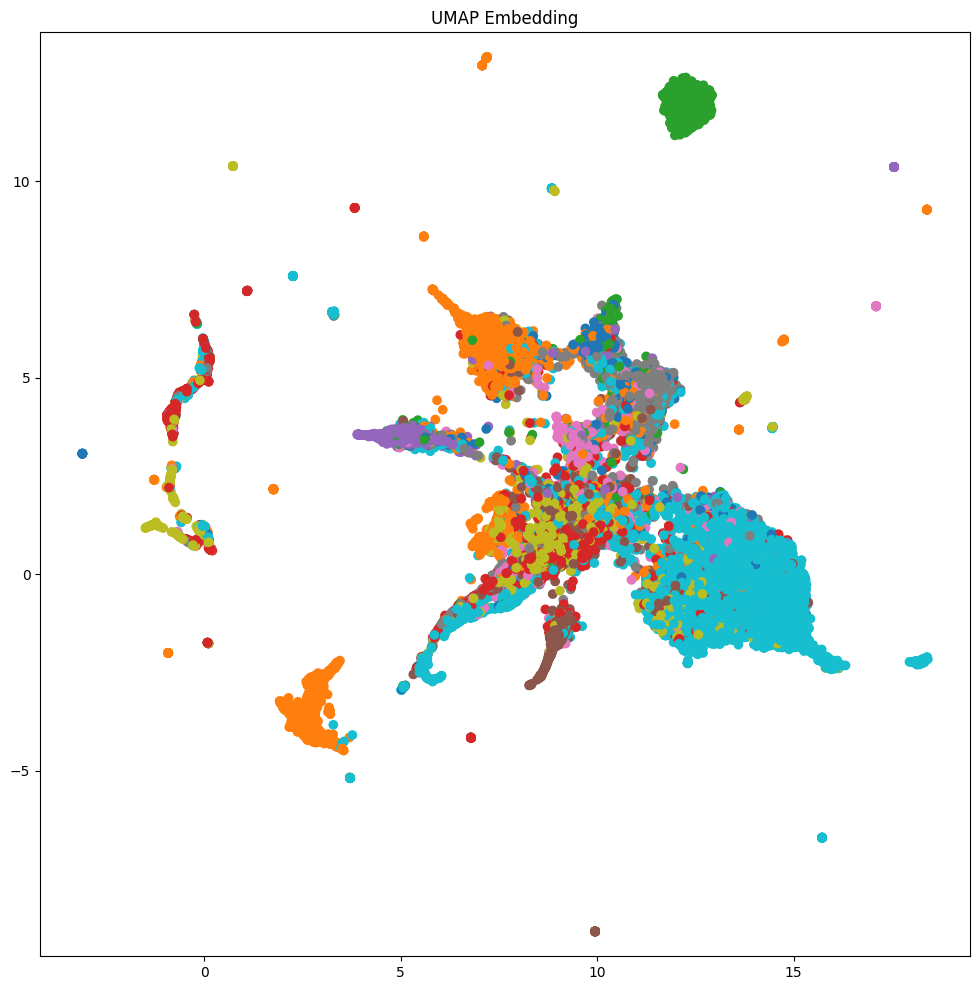

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


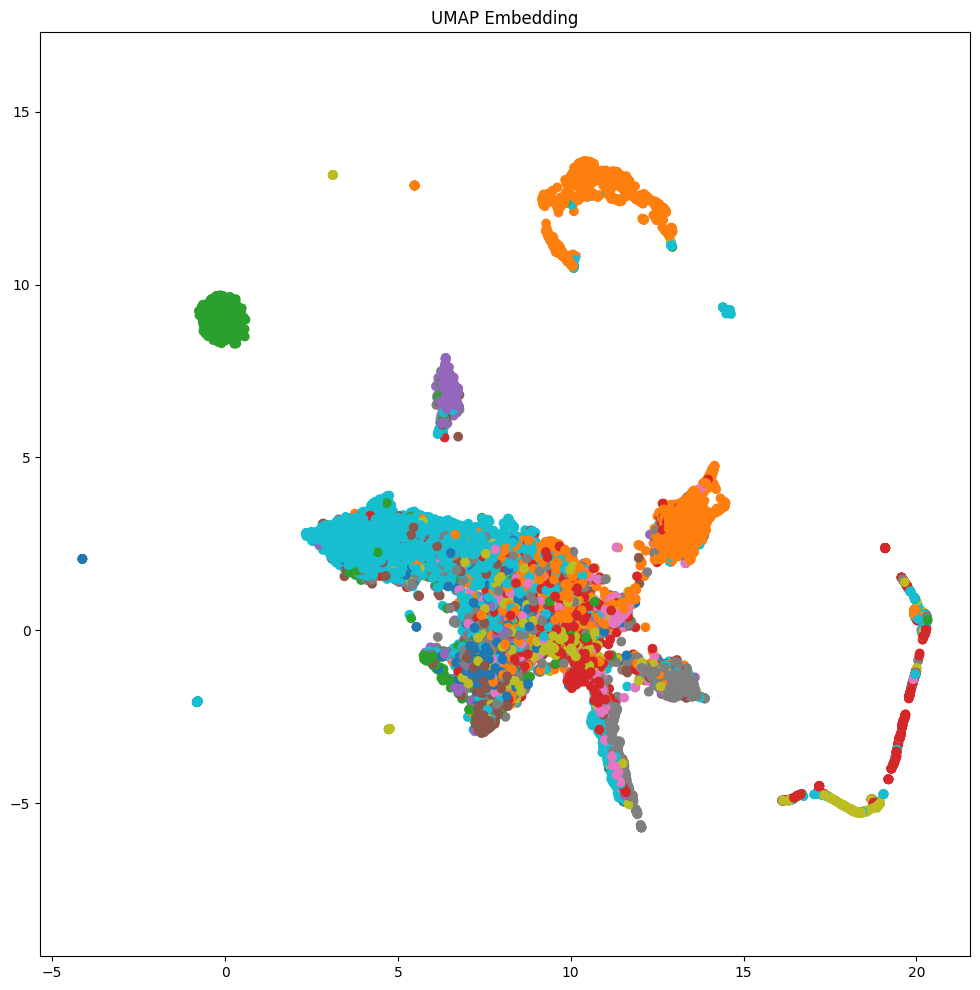

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


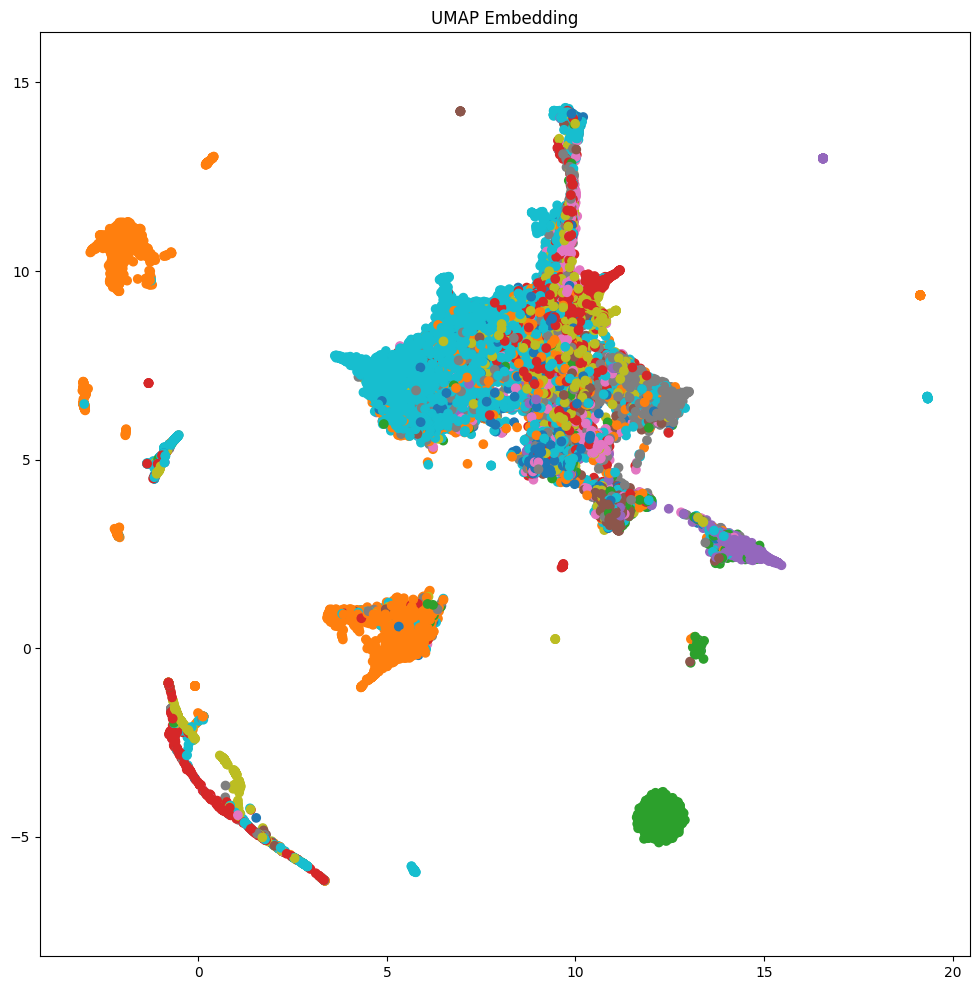

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


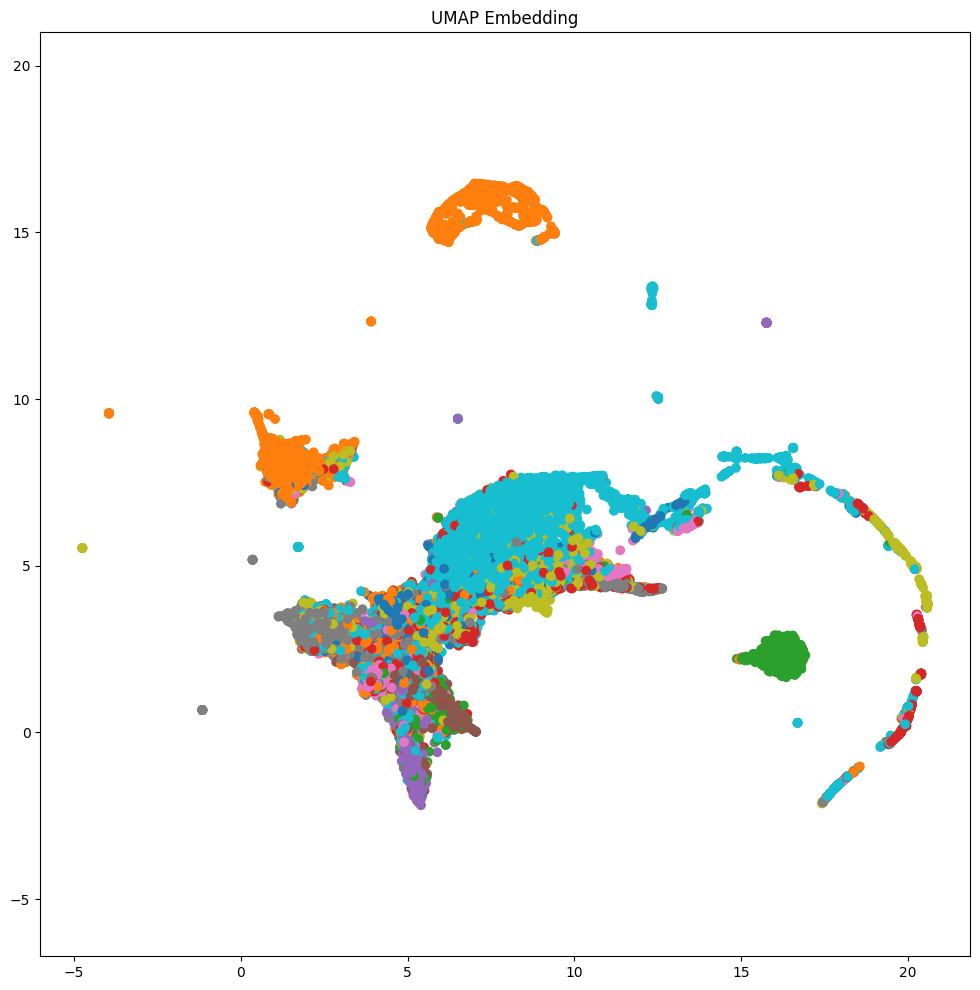

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


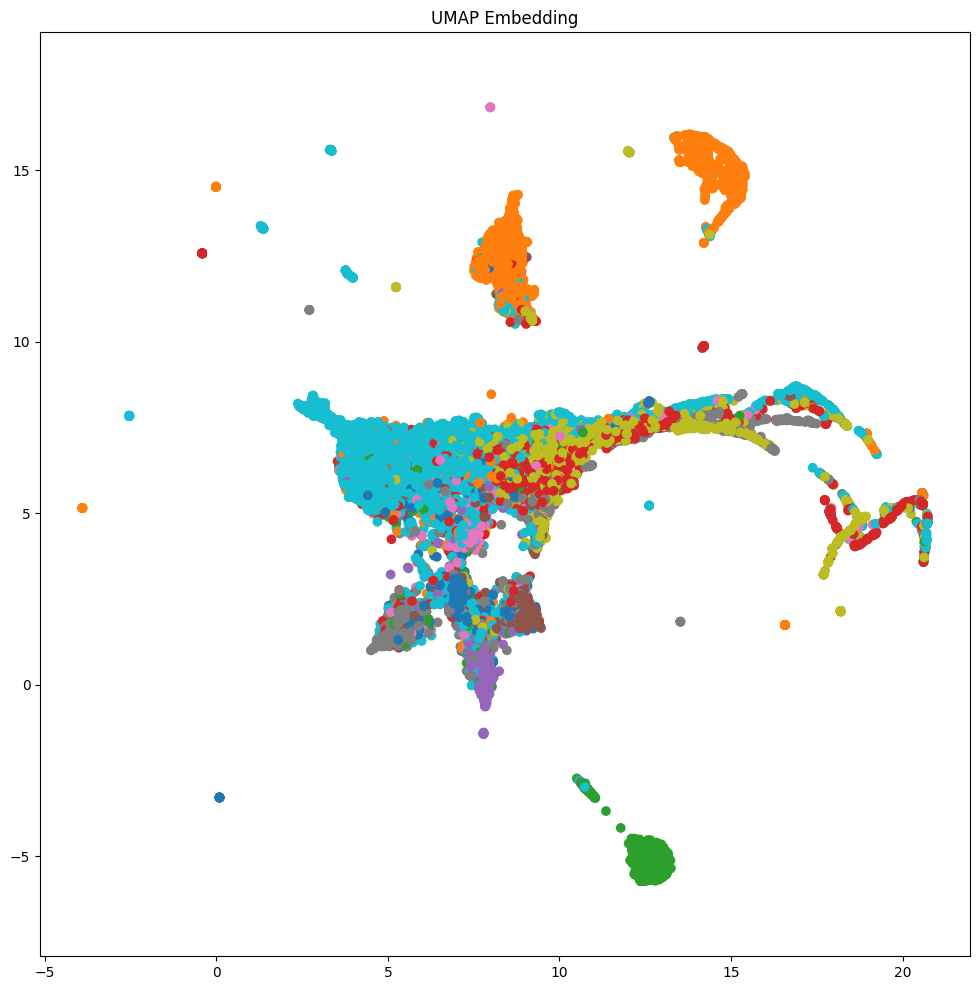

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


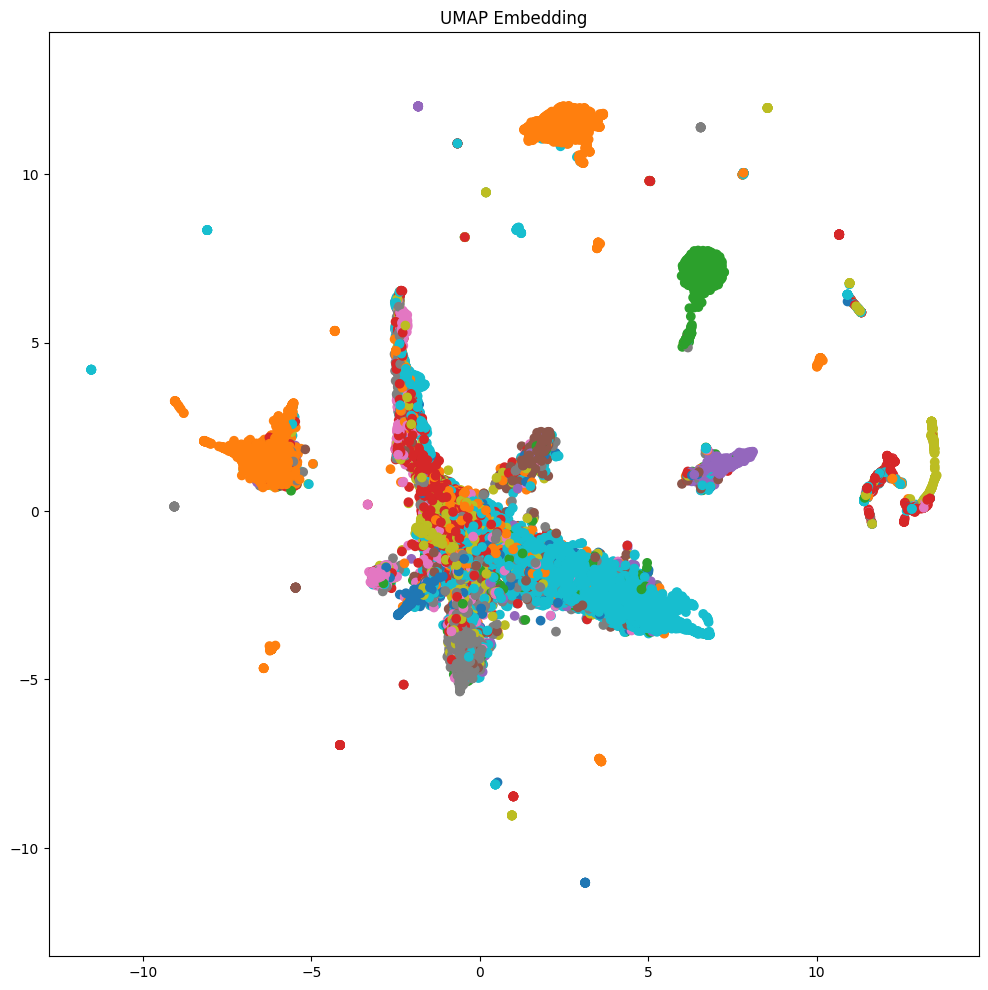

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


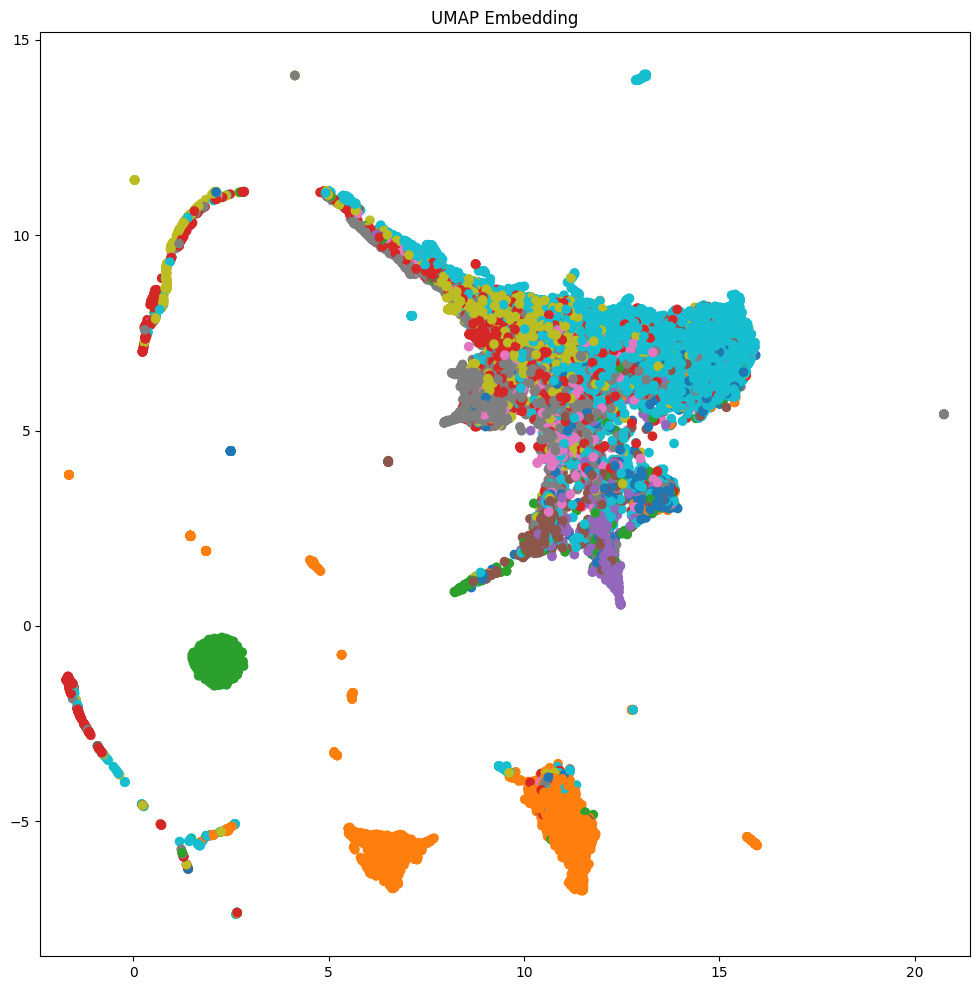

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


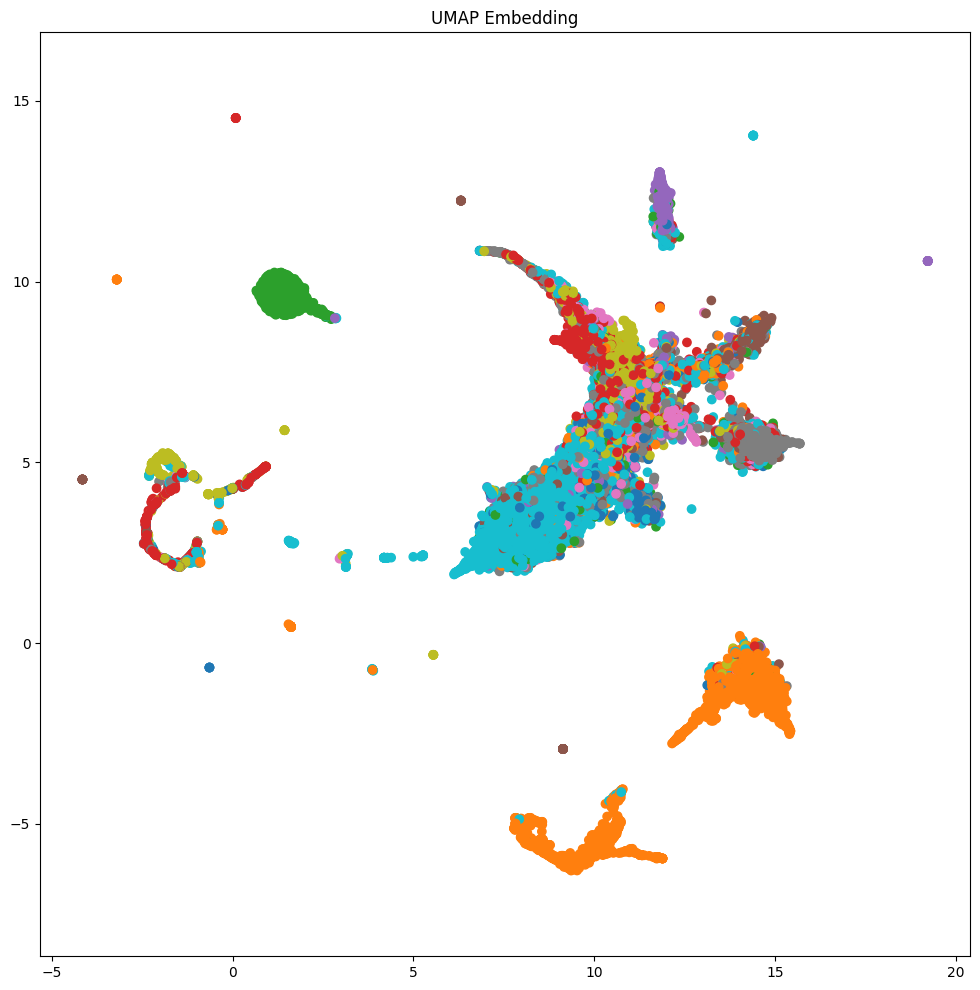

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


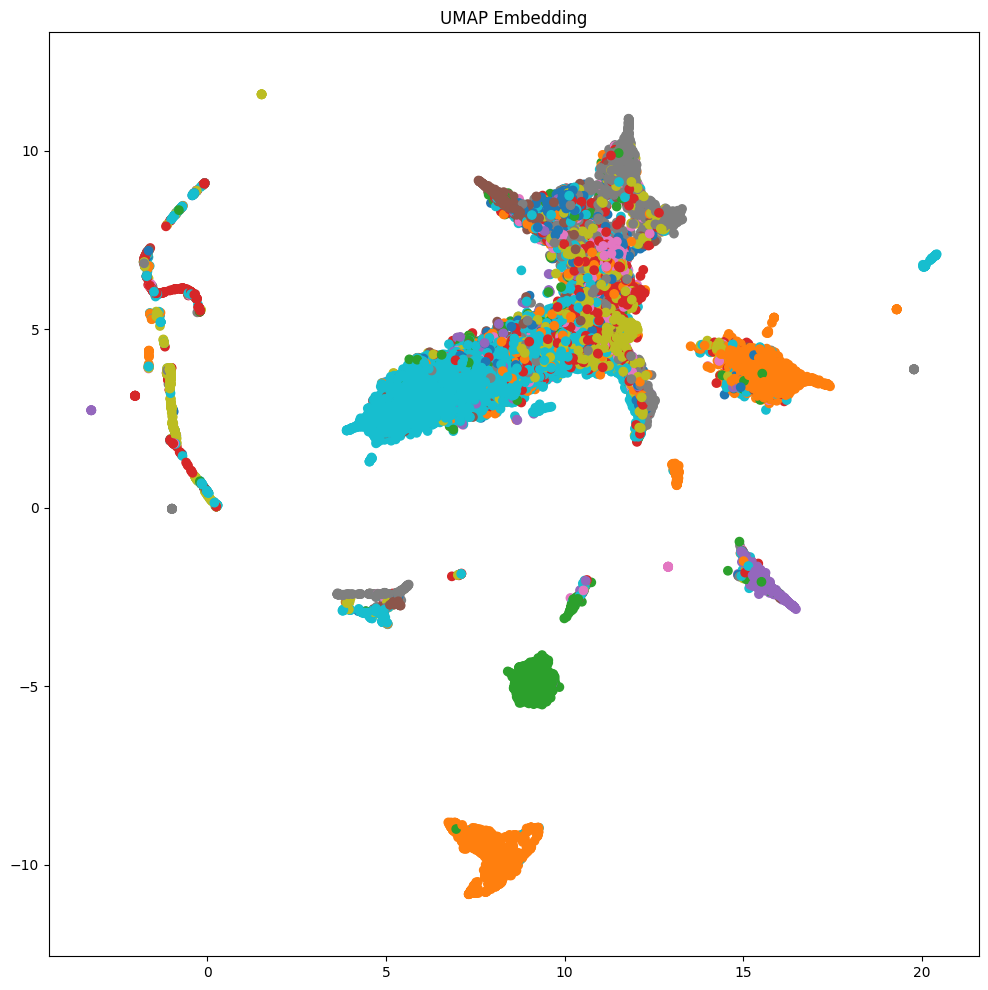

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


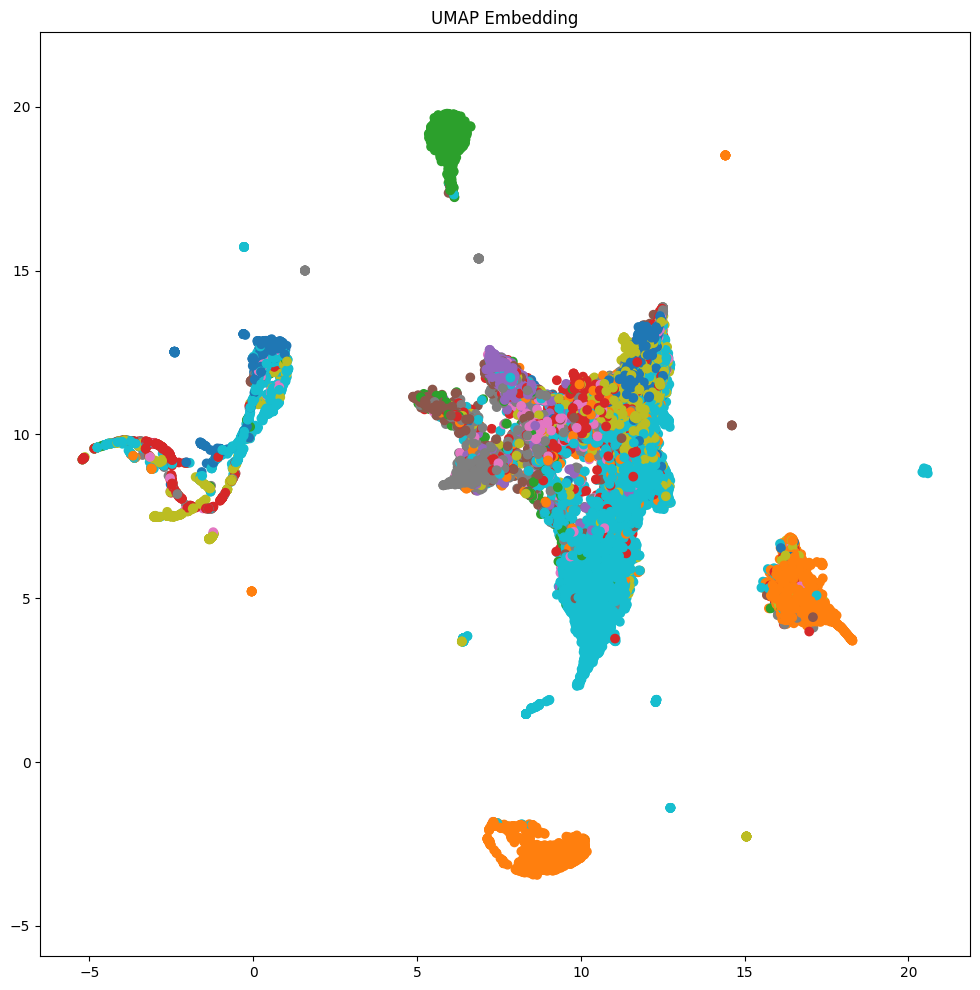

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KeyboardInterrupt: 

In [51]:
for j, p in enumerate(patch_emb):
    p_countries = dl.get_nodes(ts=dates[j])['country'].to_list()
    p_indices = [i for i in range(len(p_countries)) if p_countries[i] in most_common]
    p_labels = [most_common.index(p_countries[i]) for i in p_indices]
    p_points = p.coordinates[p_indices, :]
    umap_embedding = reducer.fit_transform(p_points)

    fig, ax = plt.subplots(1, 1, figsize=(12,12))
    ax.scatter(
        umap_embedding[:, 0],
        umap_embedding[:, 1],
        c=[sns.color_palette()[x] for x in p_labels],
        lw=1
    )
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP Embedding', fontsize=12)
    plt.show()
    

## NEW VERSION OF ALIGNMENT

In [56]:
def double_intersections_nodes(patches):
    double_intersections = dict()
    for i in range(len(patches)):
        for j in range(i+1, len(patches)):
            double_intersections[(i,j)]=list(set(patches[i].nodes.tolist()).intersection(set(patches[j].nodes.tolist())))
    return double_intersections

def preprocess_graphs(list_of_patches, nodes_dict):
    emb_list = []
    for i in range(len(list_of_patches)-1):
        emb_list.append([torch.tensor(list_of_patches[i].get_coordinates(list(nodes_dict[i,i+1]))),
                         torch.tensor(list_of_patches[i+1].get_coordinates(list(nodes_dict[i,i+1])))])
    emb_list = list(itertools.chain.from_iterable(emb_list))
    return emb_list    

class AffineTransform(nn.Module):
    def __init__(self, patch_emb, dim, n_patches):
        super(AffineTransform, self).__init__()
        
        self.R = nn.ParameterList([nn.Parameter(torch.randn(dim, dim)) for _ in range(n_patches)])
        self.s=nn.ParameterList([1] + [nn.Parameter(torch.randn(1)) for _ in range(n_patches-1)])
        self.t = nn.ParameterList([nn.Parameter(torch.randn(dim)) for _ in range(n_patches)])
        
        # Parameters for Y transformation: W2 (d x d), b2 (d)
        #self.R2 = nn.Parameter(torch.randn(d, d))
        #self.s2=nn.Parameter(torch.randn(1))
        #self.t2 = nn.Parameter(torch.randn(d))

    def forward(self, patch_emb, n_patches):
        m = 2 * n_patches - 2
        R = [self.R[0]] + [item for i in range(1, n_patches) for item in (self.R[i], self.R[i])]
        s = [self.s[0]] + [item for i in range(1, n_patches) for item in (self.s[i], self.s[i])]
        t = [self.t[0]] + [item for i in range(1, n_patches) for item in (self.t[i], self.t[i])]
        transformed_emb = [patch_emb[i] @ R[i] + t[i] for i in range(m)]
            
        return transformed_emb 

# Loss function
def loss_function(transformed_emb, rots):
    d = rots[0].shape[0]
    I = torch.eye(d)
    m = len(transformed_emb)
    
    diff = [transformed_emb[i] - transformed_emb[i+1] for i in range(0, m-1, 2)]
    
    l = sum([torch.norm(d)**2 for d in diff])

    ort_r = sum([torch.norm(R@R.T - I) for R in rots])
    loss = l + ort_r
   
    return loss

def train_model(patch_emb, dim, n_patches , num_epochs=1000, learning_rate=0.01):
    loss_hist=[]
    
    model = AffineTransform(patch_emb, dim, n_patches)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        transformed_patch_emb = model(patch_emb, n_patches)
        loss = loss_function(transformed_patch_emb, model.R)
        loss.backward(retain_graph=True)
        optimizer.step()
        loss_hist.append(loss.item())
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    
    return model, loss_hist

def get_embedding(patches, trained_model):
    scales = [1]+ [ s.detach().numpy().item() for s in trained_model.s[1:]] 
    rots = [r.detach().numpy() for r in trained_model.R]
    shifts = [ s.detach().numpy() for s in trained_model.t] 

    emb_problem = AlignmentProblem(patches)
    embedding = np.empty((emb_problem.n_nodes, emb_problem.dim))
    for node, patch_list in enumerate(emb_problem.patch_index):
        embedding[node] = np.mean([scales[i]*emb_problem.patches[p].get_coordinate(node)@rots[i] + shifts[i] for i, p in enumerate(patch_list)], axis=0)
    return embedding

In [57]:
dim = 64
num_epochs = 10000
learning_rate = 0.5
n_patches = len(patch_emb)
nodes = double_intersections_nodes(patch_emb)
emb_patches = preprocess_graphs(patch_emb, nodes)

model, loss_hist = train_model(emb_patches, dim, n_patches , num_epochs=10000, learning_rate=0.01)

embedding = get_embedding(patch_emb, model)

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 0, Loss: 780886016.0
Epoch 100, Loss: 131313360.0


KeyboardInterrupt: 